## Tests for *fpcross* module

> Cross approximation of the solution of the Fokker-Planck equation.

---
---

### Algorithm

> This is a draft of the algorithm. which is used in Solver module/class (Russian is used for simplicity).

**Задача:** найти PDF $\rho$ в момент времени $t$ на Чебышевской сетке из уравнений
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x).
$$

**Нужно** передать в крест (tt-cross) функцию (step), которая вычисляет значения $\rho_{k+1}$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки. Это позволит проинтерполировать $\rho$ на $(k+1)$-ом шаге и перейти к следующему шагу, при этом предполагается, что интерполянт для $k$-ого шага уже известен.

> На нулевом шаге имеем $\rho_0(x)$, заданную как функцию от $x$ и можем построить интерполянт очевидным образом.

> Если не используем крест (работаем в полном numpy формате), то $X$ - это полный набор точек Чебышевской сетки (алгоритм при этом остается прежним).

> Алгоритм расписан для splitting схемы первого порядка, поэтому для решения ОДЕ можем использовать метод Эйлера без потери точности.

**Работа функции step(X, I)**

> X - произвольный набор точек Чебышевской сетки (ndarray [dims, pois] of float)

> I - набор индексов узлов сетки, соответствующий точкам X (ndarray [dims, pois] of int)

**1** Найти прообразы $\widehat{X}$ (соответствуют предыдущему $k$-ому шагу) для заданного набора точек $X$ Чебышевской сетки, которые приводили бы траекторию детерминированного уравнения ($\beta = 0$) в точки $X$ на $(k+1)$-ом шаге, интегрируя назад уравнение
$$
    \frac{\partial \, x}{\partial \, t} = f(x, t),
    \quad
    x_{k+1} = X,
    \quad
    x_{k} = \widehat{X} = ?,
$$
используя формулу Эйлера
$$
    \widehat{X} = X - h \cdot f(X, t_{k+1}).
$$

**2** Используя известный интерполянт на $k$-ом шаге, вычислить значения PDF $\widehat{\rho}$ в точках $\widehat{X}$.

**3** Положить нулевое значение для $\widehat{\rho}$ в тех точках из $\widehat{X}$, которые оказались вне пределов интерполяции.

**4** Решить PDE с однородными граничными условиями Дирихле для $(k+1)$-ого шага
$$
    \frac{\partial v}{\partial t} = \Delta v,
    \quad
    v_{k} = \widehat{\rho},
    \quad
    v_{k+1} = v = ?,
$$
используя дифференциальную матрицу Чебышева
$$
v = e^h \left( e^D \otimes \ldots \otimes e^D \right) \widehat{\rho},
$$

**5** Решить ODE для $k+1$-ого шага
$$
    \frac{\partial \, \log{w}}{\partial \, t} = -tr \left[ f_x(x, t) \right],
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = w = ?,
$$
используя формулу Эйлера
$$
    \log{w} =
        \log{\widehat{\rho}} -
        h \cdot tr \left[ \frac{\partial \, f}{\partial \, x}(\widehat{X}, t_{k+1}) \right].
$$

**6** Вернуть значение $w$ как приближение $\rho(x)$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки на $(k+1)$-ом шаге.

In [1]:
import sys

import numpy as np

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver

---
---

### Solution of the multivariate Ornstein–Uhlenbeck process

> See [Alternative way to derive the distribution of the multivariate Ornstein–Uhlenbeck process](https://advancesindifferenceequations.springeropen.com/articles/10.1186/s13662-019-2214-1)

Consider SDE of the form
$$
    d \, x(t) = \theta \left( \mu - x(t) \right) d \, t + \sigma d \, \beta(t),
$$
where

- $x \in R^d$ is a stochastic process;

- $\beta \in R^q$ is a Brownian motion;

- $\mu \in R^{d}$ is the long-term mean;

- $\theta \in R^{d \times d}$ is the velocity (invertible real matrix);

- $\sigma \in R^{d \times q}$ are the friction coefficients (positive real matrix).

It can be shown that

- Mean vector of solution is
$
    M(t, x_0) = e^{-\theta t} x_0 + \left( I - e^{-\theta t} \right) \mu
$;

- Covariance matrix of solution is
$
    \Sigma(t) = \int_0^t e^{\theta (s-t)} \sigma \sigma^T e^{\theta^T (s-t)} d \, s
$;

- Probability density function of solution is
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{ | 2 \pi \Sigma(t) | }}
        exp \left[
            -\frac{1}{2} (x-M(t, x_0))^T \Sigma^{-1}(t) (x-M(t, x_0))
        \right]
$.

- The (multivariate) Ornstein–Uhlenbeck process, at any time, is a (multivariate) normal random variable.

- The Ornstein–Uhlenbeck process is mean-reverting (the solution tends to its long-term mean $\mu$ as time $t$ tends to infinity) if all eigenvalues of $\theta$ are positive (if $\theta > 0$ in the one dimensional case).

---

#### Solution of the 1D Ornstein–Uhlenbeck process

Let $\mu = 0$ and $\sigma = 1$, then we have

- Mean value
$
    M(t, x_0) = e^{-\theta t} x_0
$;

- Covariance matrix
$
    \Sigma(t) = \frac{1 - e^{-2 \theta t}}{2 \theta} 
$;

- Probability density function
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{2 \pi \Sigma(t)}}
        exp \left[
            -\frac{(x-M(t, x_0))^2}{2 \Sigma(t)}
        \right] =  
            \sqrt{
                \frac{\theta}{\pi \left( 1 - e^{-2 \theta t} \right)}
            }
            e^{\frac
                {-\theta \left( x - x_0 e^{-\theta t} \right)^2}
                {1 - e^{-2 \theta t}}
            }
$.

In [2]:
v = 1.
m = 0.
s = 1.

def func_f(x):
    return v * (-1. * x + m)

def func_f_der(x):
    return -1. * v * np.ones(x.shape)

def func_r0(x):
    r = 1./np.sqrt(2.*np.pi * s**2)
    r*= np.exp(-1. * (x - m)**2 / 2. / s**2)
    return r.reshape(-1)

def func_x_m(t, x0):
    return np.exp(-1. * v * t) * x0
 
def func_x_c(t):
    return (1. - np.exp(-2. * v * t)) / 2. / v

def func_r(x, t, x0):
    m = func_x_m(t, x0)
    c = func_x_c(t)
    return np.exp(-0.5 * (x - m)**2 / c) / np.sqrt(2. * np.pi * c)

Info
--- Time grid
Time points : 10
Time min    : 0.00e+00
Time max    : 1.00e+00
--- Time
Prep        : 3.73e-03 sec. 
Calc        : 1.45e-02 sec. 
Info from Intertrain
------------------ Parameters
Format           : NP
Dimensions       :        1
Dim 1  | Poi 10  | Min -3.000 | Max 3.000  |
------------------ Time
Init             : 8.17e-04 sec. 
Prep             : 1.08e-04 sec. 
Calc (average)   : 1.31e-04 sec. 
Func (average)   : 8.15e-05 sec. 
------------------ Test (random points)
Number of points : 10
Error (max)      :      inf 
Error (mean)     :      inf 
Error (min)      : 5.23e-03 
------------------


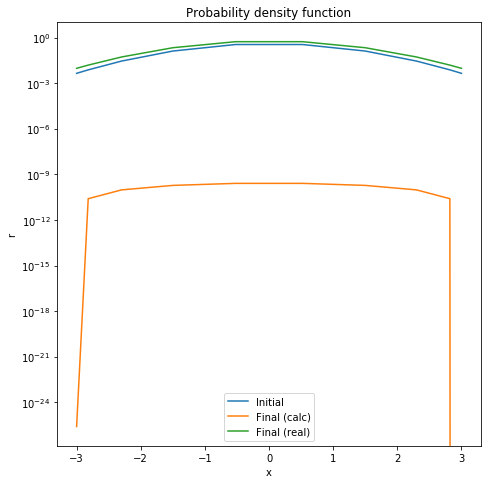

In [7]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(10)
SL.set_grid_x(10)
SL.set_funcs(func_f, func_f_der, func_r0, func_r)
SL.prep()
SL.calc()
SL.info()
SL.plot()

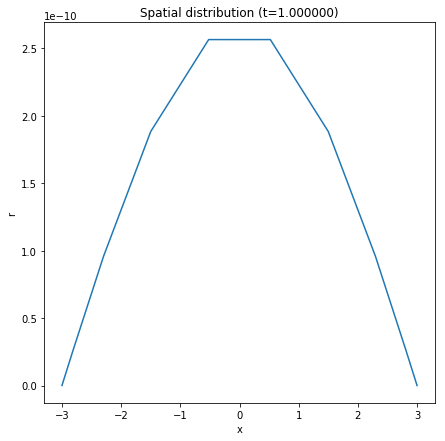

In [9]:
SL.anim(ffmpeg_path='./../tmp/ffmpeg', delt=200)

---

#### Solution of the 2D Ornstein–Uhlenbeck process

In [5]:
A = 1.
A = np.array([
    [1., 0.],
    [0., 1.]
])
def func_f(x):
    return A@x

def func_f_der(x):
    return A@np.ones(x.shape)

def func_r0(x):
    r = np.exp(-0.5 * np.diag(x.T@x)).reshape(-1, 1)
    
    return r.reshape(-1)

In [6]:
SL = Solver(d=2, with_tt=False)
SL.set_grid_t(5)
SL.set_grid_x(10)
SL.set_funcs(func_f, func_f_der, func_r0)
SL.prep()
SL.calc()
SL.info()
SL.plot()

ValueError: shapes (10,10) and (100,) not aligned: 10 (dim 1) != 100 (dim 0)

In [ ]:
SL.anim(ffmpeg_path='./../tmp/ffmpeg', delt=200)

---
---